In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from src.manager import DbManager

dbm = DbManager('../data/vast.db')
dbm.connect()

In [3]:
ts_idx = dbm.table_to_df('ts_idx').timestamp
ts_idx.diff().describe()

count    4621.000000
mean       55.264878
std         8.103254
min        21.000000
25%        53.000000
50%        54.000000
75%        56.000000
max       161.000000
Name: timestamp, dtype: float64

C:\Users\ergot\mambaforge\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ergot\mambaforge\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


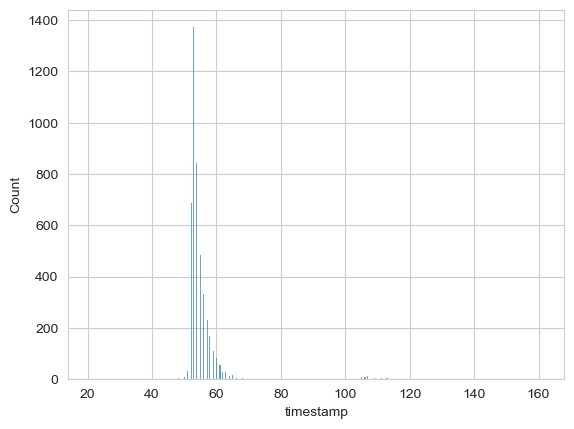

In [4]:
sns.histplot(ts_idx.diff());

In [5]:
cost = dbm.table_to_df('cost_ts').set_index('machine_id')




In [6]:
df = cost[['dph_base', 'timestamp']]
df = df.loc[14096]
mask = df.dph_base.shift() != df.dph_base
df.loc[mask]

,dph_base,timestamp
machine_id,,
14096,440,1697699070


In [7]:
df = pd.DataFrame({'dph_base': [100, 100 , 200, 200, 250, 200], 
                   'timestamp': [1, 2, 3, 1, 2, 3]},
                  # columns=['dph_base', 'timestamp'],
                  index=[32, 32, 32, 120, 120, 120])
df.index.name = 'machine_id'
df

,dph_base,timestamp
machine_id,,
32,100,1
32,100,2
32,200,3
120,200,1
120,250,2
120,200,3


In [8]:
def drop_dph_duplicates(df_):
    return df_.loc[df_.dph_base.shift() != df_.dph_base]

In [9]:
df.groupby('machine_id').apply(drop_dph_duplicates).reset_index(level=0, drop=True)

,dph_base,timestamp
machine_id,,
32,100,1
32,200,3
120,200,1
120,250,2
120,200,3


In [10]:
cost = cost[['dph_base', 'timestamp']].groupby('machine_id').apply(drop_dph_duplicates).reset_index(level=0, drop=True)
cost

,dph_base,timestamp
machine_id,,
63,1000,1697699070
63,250,1697913955
63,150,1697917643
63,500,1697918554
162,600,1697699070
...,...,...
14437,140,1697945185
14437,110,1697947602
14437,120,1697947709


In [11]:
rent = dbm.table_to_df('rent_ts').set_index('machine_id')
rent_count = rent.groupby('machine_id')['timestamp'].count().sort_values(ascending=False)
rent_count

machine_id
13785    1390
6160      967
11038     787
13672     427
7135      313
         ... 
12056       1
12044       1
12038       1
12037       1
14439       1
Name: timestamp, Length: 2092, dtype: int64

In [12]:
cost_count = cost.dph_base.groupby('machine_id').count().sort_values(ascending=False)
cost_count

machine_id
3059     380
3056     380
8960     379
8298     353
4383     147
        ... 
11031      1
11016      1
10991      1
10988      1
14439      1
Name: dph_base, Length: 2092, dtype: int64

In [13]:
set(rent_count[rent_count > 15].index) & set(cost_count[cost_count > 15].index)

{3056,
 3059,
 4383,
 4384,
 8298,
 8960,
 9599,
 11851,
 12167,
 12204,
 13010,
 13058,
 13098,
 13626,
 13641,
 14017,
 14145,
 14184,
 14316}

In [14]:
mach_id = 8506
gpus_rented = rent.loc[[mach_id]].set_index('timestamp').num_gpus_rented
gpus_rented

timestamp
1697699070    4
Name: num_gpus_rented, dtype: int64

In [15]:
costs = cost.loc[[mach_id]].set_index('timestamp', drop=True)
costs

,dph_base
timestamp,
1697699070,2200


In [16]:
df = pd.concat([gpus_rented, costs], axis=1)
df

,num_gpus_rented,dph_base
timestamp,,
1697699070,4,2200


In [17]:
df.ffill(inplace=True)
df

,num_gpus_rented,dph_base
timestamp,,
1697699070,4,2200


In [18]:
df[:-1]

,num_gpus_rented,dph_base
timestamp,,


In [19]:
df.index

Index([1697699070], dtype='int64', name='timestamp')

In [20]:
df.index.diff()[1:]

Index([], dtype='float64', name='timestamp')

In [21]:
duration = df.index.diff()[1:]
df = df[:-1].copy()
df['duration'] = duration
df

,num_gpus_rented,dph_base,duration
timestamp,,,


In [22]:
num_gpus = 4
(df.num_gpus_rented / num_gpus * df.dph_base / 1000 * df.duration / 3600).sum()

0.0

In [23]:
dbm.close()